In [1392]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1393]:
import pyspiel
import open_spiel.python.games
from open_spiel.python.observation import make_observation
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator
from open_spiel.python.examples.straightforward_agent import StraightforwardAgent
from open_spiel.python.pytorch.mutations import *
from open_spiel.python.examples.ppo_utils import EnvParams
from open_spiel.python.examples.ppo_eval import eval_agents_parallel
from open_spiel.python.env_decorator import *

from auctions.webutils import *
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
import numpy as np 
import pandas as pd
from absl import logging
import tempfile
import subprocess

import open_spiel.python.games
from open_spiel.python.examples.ubc_utils import *
from open_spiel.python.algorithms.exploitability import nash_conv, best_response

import bokeh
from bokeh.io import curdoc
from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import row, column
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap, factor_cmap
from bokeh.palettes import Category10_10, Magma256, Spectral10, Category20_20
from bokeh.models import LinearAxis, Range1d
from bokeh.models import ColumnDataSource, FactorRange

from bokeh.resources import CDN
from bokeh.embed import file_html

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from django.db.models import F
from auctions.models import *

import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Category10_10, Magma256, Spectral10, Category20_20
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from open_spiel.python.examples.ubc_cma import *

import itertools
output_notebook()
from open_spiel.python.examples.ubc_cma import *
from open_spiel.python.examples.env_and_policy import *
from open_spiel.python.examples.ppo_eval import run_eval
from open_spiel.python.examples.straightforward_agent import StraightforwardAgent

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

plt.matplotlib.rcParams['figure.dpi'] = 200

Loading BokehJS ...

In [699]:
# # GAME_NAME = 'confused_national'
# # GAME_NAME = 'all_confused_with_local'
# # GAME_NAME = '2rvn'
# # GAME_NAME = 'all_confused'
# # GAME_NAME = 'regional_vs_national'
# GAME_NAME = 'very_small_sats_complete_symmetric'


# PYSATS = '/apps/sats/python'
# !python {PYSATS}/pysats.py --config_file {PYSATS}/{GAME_NAME}.yml --seed 777 --output_file {PYSATS}/{GAME_NAME}.json
# GAME_NAME = f'{PYSATS}/{GAME_NAME}'

# Naive version

In [844]:
# GAME_NAME = 'sats_2regions_2licenses_2players_5types'
# GAME_NAME = 'confused_national'
# GAME_NAME = '/apps/sats/python/regional_vs_national'

# GAME_NAME = 'april6_t1'


In [1574]:
# # assume 2 regions and 1 type per player
# max_price_increments = 20

# # game-wide setup
# packages = game.auction_params.all_bids
# supply = game.auction_params.licenses
# license_names = game.auction_params.license_names
# opening_prices = game.auction_params.opening_prices
# increment = game.auction_params.increment
# player_types = game.auction_params.player_types
# total_budget = game.auction_params.max_total_spend

# records = []
# for num_price_increments in itertools.product(range(0, max_price_increments+1), repeat=2):
#     prices = opening_prices * (1 + increment) ** np.array(num_price_increments)
#     package_prices = packages @ prices
    
#     bids = {}
#     total_demand = np.zeros_like(supply)
#     for player_index, player_type in player_types.items(): # TODO why is this a loop don't loop
#         bidder = player_types[player_index][0]['bidder']
#         profits = bidder.get_profits(prices)
#         profits[package_prices > bidder.budget] = -1
#         bid = packages[np.argmax(profits)]
#         bids[player_index] = tuple(bid)
#         total_demand += bid
    
#     record = {}
#     for i, license_name in enumerate(license_names):
#         record[f'increments_{license_name}'] = num_price_increments[i]
#     for player_index, player_type in player_types.items(): # ???
#         record[f'bids_{player_index}'] = bids[player_index]
#     record['auction_over'] = np.all(total_demand <= supply)
#     record['prices_feasible'] = (package_prices[-1] <= total_budget)
#     records.append(record)
    
# df = pd.DataFrame.from_records(records)

In [1575]:
# df['combined'] = df.apply(lambda row: (row['bids_0'], row['bids_1']), axis=1)
# unique_allocations = df['combined'][df['auction_over']].unique()
# palette = sns.color_palette('hls', len(unique_allocations))
# np.random.shuffle(palette)
# colors = {allocation: palette[i] for i, allocation in enumerate(unique_allocations)}
# df['color'] = df['combined'].map(colors)
# df.loc[~df['auction_over'], 'color'] = 'lightgrey'
# df.loc[~df['prices_feasible'], 'color'] = 'darkgrey'

In [1576]:
# plt.figure(figsize=(10,10))

# increment_columns = df.columns[df.columns.str.startswith('increments_')]
# plt.scatter(
#     x=df[increment_columns[0]],
#     y=df[increment_columns[1]],
#     c=df['color'],
#     s=100
# )

# import matplotlib.patches as mpatches
# from matplotlib.lines import Line2D

# patches = [
#     Line2D([0], [0], marker='o', color=colors[allocation], label=allocation, markerfacecolor=colors[allocation])
#     for allocation in colors
# ]
# plt.legend(handles=patches)

# plt.show()


# CFR parsing version

In [1577]:
GAME_NAME = 'may3_slow'
game = pyspiel.load_game('python_clock_auction', dict(filename=f'{GAME_NAME}.json'))
np.random.seed(1234)
# FILE_NAME = f'{GAME_NAME}/strategy.csv'
# FILE_NAME = '

def columns_to_use(c):
    return 'Allocation' in c or 'Price' in c or c in ['player', 'terminal', 'prob', 'round']

def row_to_alloc(row):
    return ' '.join(map(str, row[allocation_columns].values))

def sum_digits(s):
    return  (sum(int(x) for x in s if x.isdigit()), sorted(s))

def add_alpha(row):
    if not pd.isnull(row['color']):
        return row['color'] + (max(0.001, row['prob']),)

cfr_df = pd.read_csv(FILE_NAME, usecols=columns_to_use)
price_columns = cfr_df.columns[cfr_df.columns.str.startswith('Price')]
increment = game.auction_params.increment
def to_increment(price, start_price, increment):
    return tuple(map(int, np.round(1 + (np.log(price / start_price) / np.log(1 + increment)))))

start_prices = cfr_df[price_columns].min().values
cfr_df['increments'] = [to_increment(p, start_prices, increment) for p in cfr_df[price_columns].values]

# TODO: The allocations don't work

terminal_cfr_df = cfr_df.query('terminal and player == 0').drop('player', axis=1).copy()
allocation_columns = [c for c in cfr_df.columns if 'Allocation' in c]
terminal_cfr_df['allocation'] = terminal_cfr_df.apply(row_to_alloc, axis=1)
terminal_cfr_df = terminal_cfr_df.drop(allocation_columns, axis=1)
unique_allocations = terminal_cfr_df['allocation'].unique()
unique_allocations = sorted(unique_allocations, key=sum_digits)
palette = sns.color_palette('hls', len(unique_allocations))
np.random.shuffle(palette)
size_list = np.linspace(5, 40, len(unique_allocations))**2
colors = {allocation: palette[i] for i, allocation in enumerate(unique_allocations)}
sizes = {allocation: size_list[i] for i, allocation in enumerate(unique_allocations)}

terminal_cfr_df['color'] = terminal_cfr_df['allocation'].map(colors)
terminal_cfr_df['alphacolor'] = terminal_cfr_df.apply(add_alpha, axis=1)
terminal_cfr_df['size'] = terminal_cfr_df['allocation'].map(sizes)

In [1578]:
# GAME_NAME = 'bluff'
# game = pyspiel.load_game('python_clock_auction', dict(filename=f'{GAME_NAME}.json'))
# state = game.new_initial_state().child(0).child(0).child(1).child(1)
# state

In [1579]:
# record = dict()
# num_products = 1
# product_names = 'A'
# if state.is_terminal() :
#     allocation = state.get_allocation()
#     record.update({f'Allocation {product_names[i]}': allocation[i] for i in range(num_products)})
# record

In [1580]:
# state.get_allocation()

In [1581]:
# GAME_NAME = 'april6_t1'
# game = pyspiel.load_game('python_clock_auction', dict(filename=f'{GAME_NAME}.json'))
# state = game.new_initial_state().child(0).child(0).child(1).child(1).child(0).child(0).child(0)
# state.get_allocation()

In [1582]:
# [bidder.processed_demand[-1] for bidder in self.bidders]

# Build the arrows

In [1583]:
# You start with all of your flow at (1,1). You "leak" some there if the auction can end then, otherwise the rest of the flow heads into other info states
FLOW_CUTOFF = 1e-6

leaks = terminal_cfr_df.groupby('increments')['prob'].sum().to_dict() 
flows = cfr_df.query('~terminal and player == 0').groupby('increments')['prob'].sum().to_dict()

q = {(1,) * game.auction_params.num_products}
arrows = [] # (StartX, startY, Xlen, Ylen, alpha)
processed = set()

def to_price(increments, start_price):
    return start_price * (1 + increment) ** (increments - 1)

while len(q) > 0:
    n = q.pop()
    if n in processed:
        continue
    outgoing_flow = flows[n] - leaks[n]
    price = to_price(np.array(n), start_prices)
    neighbour_flows = dict()
    
    # Find total neighbour flow: we use this value to normalize the outgoing flows
    for i in range(len(n)):
        x = np.zeros(len(n))
        x[i] = 1
        neighbour = tuple(np.array(n) + x)
        if neighbour in leaks:
            neighbour_flow = leaks.get(neighbour, 0) + flows.get(neighbour, 0)
            if neighbour_flow > FLOW_CUTOFF:
                neighbour_flows[neighbour] = neighbour_flow
    
    neighbour_total_flow = sum(neighbour_flows.values())
    
    # Find neighbours and add arrows 
    for neighbour, neighbour_flow in neighbour_flows.items():
        # Process neighbour later
        q.add(neighbour)
        new_price = to_price(np.array(neighbour), start_prices)
        alpha = max(0, outgoing_flow * (neighbour_flow / neighbour_total_flow))
        arrows.append((price[0], price[1] if game.auction_params.num_products > 1 else 1, new_price[0] - price[0], new_price[1] - price[1]  if game.auction_params.num_products > 1 else 0, alpha))

    processed.add(n)

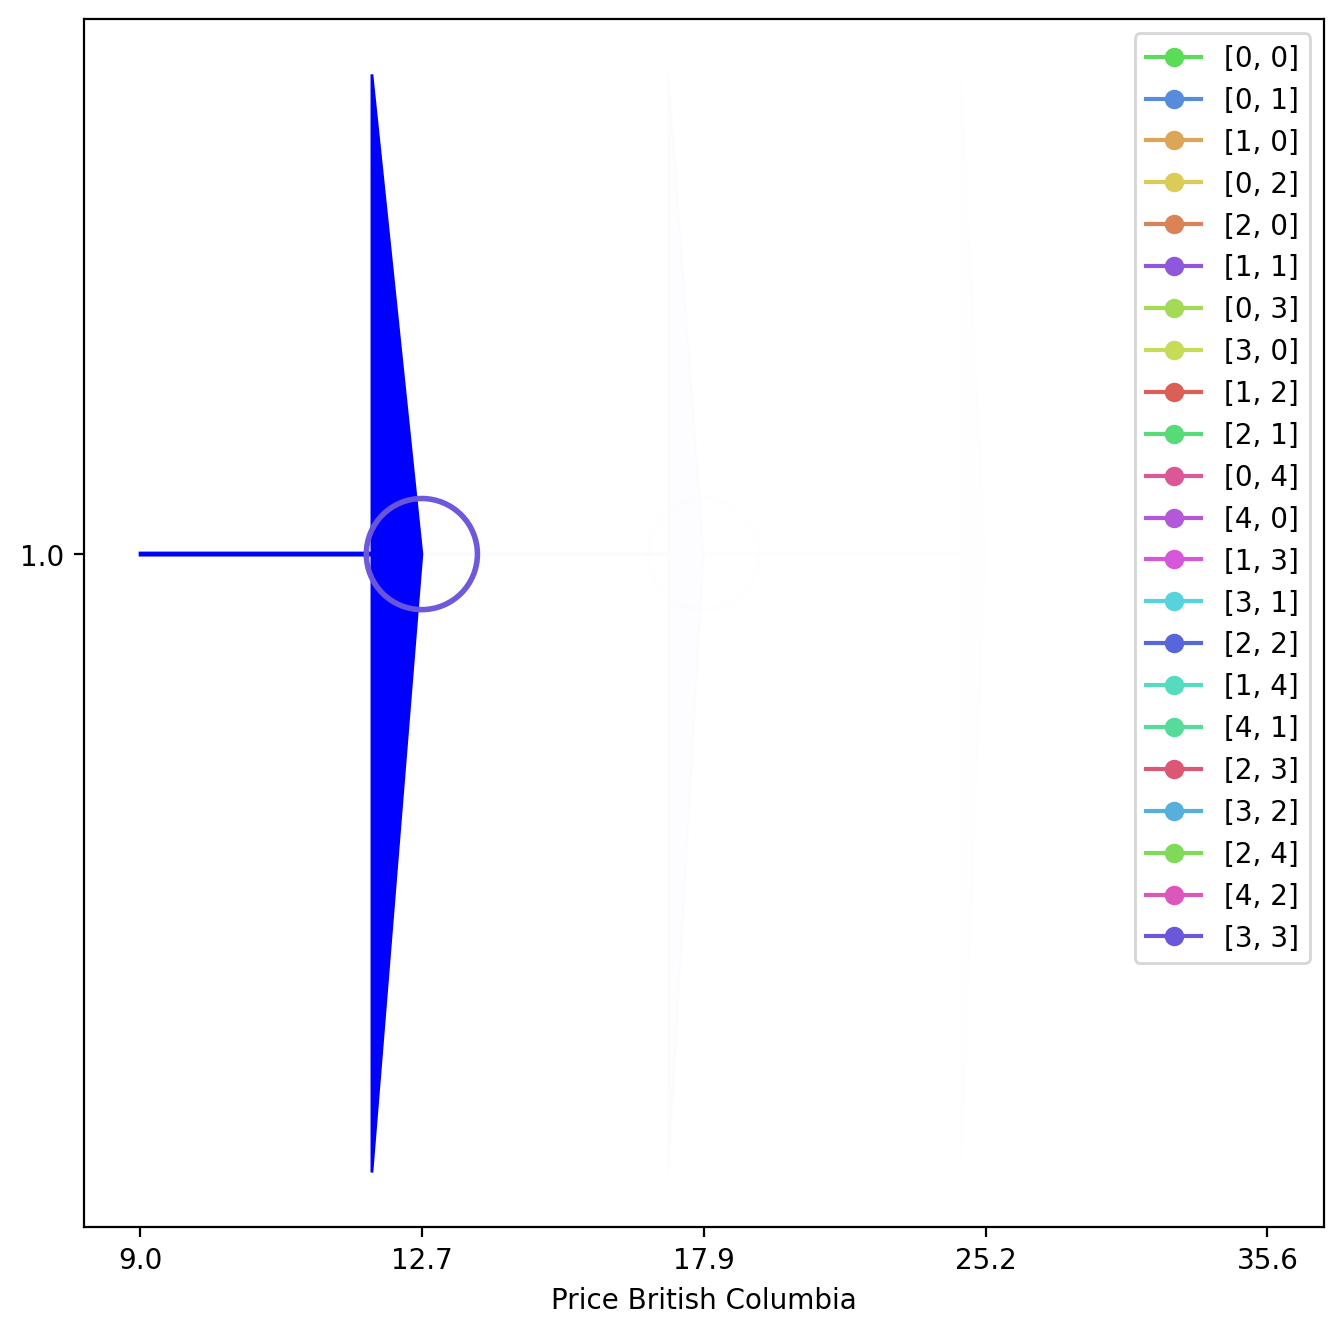

In [1584]:
SHOW_SOLUTION = True

plt.figure(figsize=(8, 8))

plt_x = terminal_cfr_df[price_columns[0]]
plt_y = terminal_cfr_df[price_columns[1]] if game.auction_params.num_products > 1 else [1] * len(plt_x)

plt.scatter(
    x=plt_x,
    y=plt_y,
    edgecolors=terminal_cfr_df['alphacolor'] if SHOW_SOLUTION else terminal_cfr_df['color'],
    facecolors='none',
    linewidths=2,
    s=terminal_cfr_df['size'],
)

if SHOW_SOLUTION:
    for arrow in arrows:
        plt.arrow(arrow[0], arrow[1], arrow[2] , arrow[3],  
            shape='full', color='b', length_includes_head=True,  zorder=0, alpha=arrow[4], head_width=0.5)


patches = [
    Line2D([0], [0], marker='o', color=colors[allocation], label=allocation, markerfacecolor=colors[allocation])
    for allocation in colors
]
plt.legend(handles=patches)

plt.semilogx()
plt.semilogy()

plt.xlabel(price_columns[0])

plt.xticks(plt_x.unique(), plt_x.unique())
if game.auction_params.num_products > 1:
    plt.yticks(plt_y.unique(), plt_y.unique()) 
    plt.ylabel(price_columns[1])  
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.minorticks_off()

plt.show()



In [1585]:
display(flows)
print()
display(leaks)

# cfr_df.query('terminal').groupby('round')['prob'].sum()

# # TODO: Draw the path for the particular CFR equilibrium
# # TODO: Arrows according to reach probability?
#     # The overall reach probability

# # TODO: Alpha is how likely a given ring is, normalized to 1?


{(1,): 1.0,
 (2,): 0.9993454467381999,
 (3,): 0.006330005928707005,
 (4,): 0.0020243779883506144,
 (5,): 0.00010123027175830566}

{(1,): 0.0006545532618001515,
 (2,): 0.9930154408094931,
 (3,): 0.00430562794035639,
 (4,): 0.001923147716592309,
 (5,): 0.0001012302717583057}

In [1423]:
cfr_df = pd.read_csv(FILE_NAME).query('terminal and player == 0')

In [1424]:
cfr_df.query('terminal and player == 0 and round == 1')

,info_state,Allocation British Columbia,Bid ([0]),Bid ([1]),Bid ([2]),Bid ([3]),Price British Columbia,Utility 0,Utility 1,bids,player,prob,round,terminal,total_demand,type
2,"Price: [13]\nFinal bids: [array([0]), array([0...","[0, 0]",NaN,NaN,NaN,NaN,13.0,0.0,0.0,NaN,0,2.002446e-12,1,True,NaN,0
4,"Price: [13]\nFinal bids: [array([0]), array([1...","[0, 1]",NaN,NaN,NaN,NaN,13.0,0.0,37.0,NaN,0,1.977714e-09,1,True,NaN,0
6,"Price: [13]\nFinal bids: [array([0]), array([2...","[0, 2]",NaN,NaN,NaN,NaN,13.0,0.0,54.0,NaN,0,1.700508e-11,1,True,NaN,0
8,"Price: [13]\nFinal bids: [array([0]), array([3...","[0, 3]",NaN,NaN,NaN,NaN,13.0,0.0,41.0,NaN,0,3.670478e-12,1,True,NaN,0
10,"Price: [13]\nFinal bids: [array([1]), array([0...","[1, 0]",NaN,NaN,NaN,NaN,13.0,37.0,0.0,NaN,0,2.037776e-06,1,True,NaN,0
12,"Price: [13]\nFinal bids: [array([1]), array([1...","[1, 1]",NaN,NaN,NaN,NaN,13.0,37.0,37.0,NaN,0,2.012607e-03,1,True,NaN,0
14,"Price: [13]\nFinal bids: [array([1]), array([2...","[1, 2]",NaN,NaN,NaN,NaN,13.0,37.0,54.0,NaN,0,1.730511e-05,1,True,NaN,0
40,"Price: [13]\nFinal bids: [array([2]), array([0...","[2, 0]",NaN,NaN,NaN,NaN,13.0,48.0,0.0,NaN,0,9.986944e-04,1,True,NaN,0
42,"Price: [13]\nFinal bids: [array([2]), array([1...","[2, 1]",NaN,NaN,NaN,NaN,13.0,48.0,37.0,NaN,0,9.863594e-01,1,True,NaN,0
92,"Price: [13]\nFinal bids: [array([3]), array([0...","[3, 0]",NaN,NaN,NaN,NaN,13.0,35.0,0.0,NaN,0,2.948027e-07,1,True,NaN,0


In [1425]:
cfr_df['Utility 1'] @ cfr_df['prob']

36.9276246133282

In [1426]:
cfr_df = pd.read_csv('april16_t1_copy/strategy.csv').query('terminal and player == 0')
print(cfr_df['Utility 0'] @ cfr_df['prob'])
print(cfr_df['Utility 1'] @ cfr_df['prob'])

38.80916213933183
19.88626082843018


In [1710]:
FILE_NAME = 'results/may3_very_slow_1235/strategy.csv'

import re

def unify_info_string(s):
    return re.sub(r'(sub\[.*?\])', r'sub', s)



In [1711]:

records = []

for player_index, player_df in pd.read_csv(FILE_NAME).query('~terminal').groupby('player'):
    player_df = player_df.copy()
    player_df['united_info_state'] = player_df['info_state'].apply(unify_info_string)
    for _, effective_info_state_df in player_df.groupby('united_info_state'):
        action_columns = [c for c in effective_info_state_df if 'Bid' in c]
        prob_of_is = effective_info_state_df['prob'].sum()
        if prob_of_is > 0.001:
            record = dict()
            record['auction_round'] = effective_info_state_df['round'].iloc[0]
            record['player'] = effective_info_state_df['player'].iloc[0]
            record['type'] = effective_info_state_df['type'].iloc[0]
            record = {**record, **effective_info_state_df[action_columns].mean(axis=0).to_dict()}
            records.append(record)
    


In [1712]:
df = pd.DataFrame.from_records(records)
df_long = df.melt(id_vars=['auction_round', 'player', 'type'], value_name = 'Prob', var_name = 'Bid')

In [1713]:
df_long['Bid'] = df_long['Bid'].str.replace('Bid ', '')
df_long['type'] = df_long.apply(lambda row: f"P{row['player']}_{row['type']}", axis=1)

In [1714]:
df_long['type'].value_counts()

P1_0    16
P0_0    16
Name: type, dtype: int64

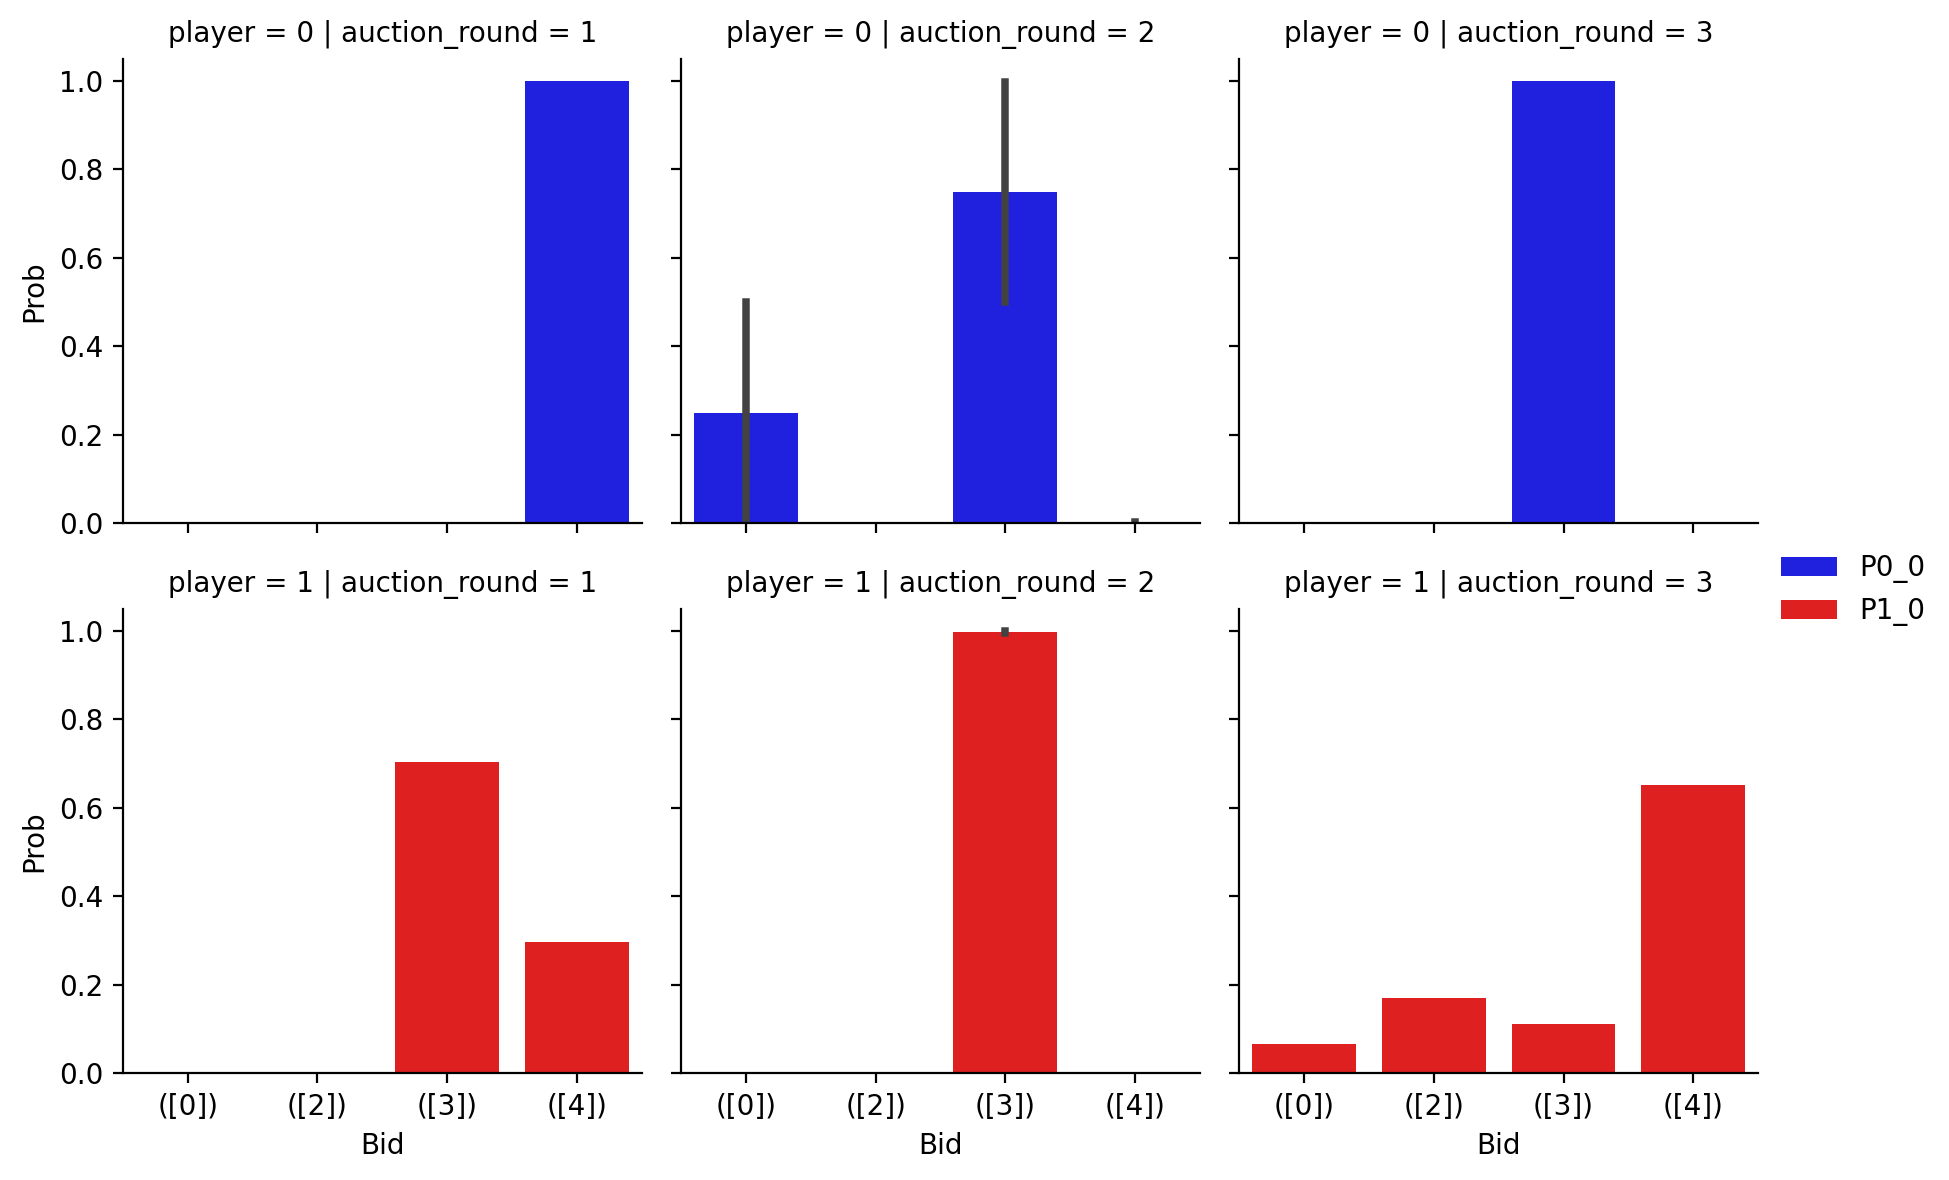

In [1715]:
g = sns.FacetGrid(df_long, col="auction_round", row="player")

palette = dict(P0_0 = 'blue', P1_0='red')

g.map_dataframe(sns.barplot, x="Bid", y="Prob", palette=palette, hue="type")
g.add_legend()

In [1666]:
cfr_df = pd.read_csv(FILE_NAME).query('round == 2 and player == 1 and ~terminal').round(2).sort_values('prob', ascending=False)
cfr_df

,info_state,Allocation British Columbia,Bid ([0]),Bid ([2]),Bid ([3]),Bid ([4]),Price British Columbia,Utility 0,Utility 1,bids,player,prob,round,terminal,total_demand,type
69,"p1t0 a4 agg[array([0]), array([8])] sub[array(...",NaN,0.00,0.00,1.00,0.0,12.69,NaN,NaN,"[array([0]), array([4])]",1,1.0,2,False,[8],0
25,"p1t0 a4 agg[array([0]), array([7])] sub[array(...",NaN,0.00,0.00,0.00,1.0,12.69,NaN,NaN,"[array([0]), array([4])]",1,0.0,2,False,[7],0
53,"p1t0 a3 agg[array([0]), array([7])] sub[array(...",NaN,0.33,0.33,0.33,NaN,12.69,NaN,NaN,"[array([0]), array([3])]",1,0.0,2,False,[7],0


In [1593]:
# STRINGS = ["UKRAINE", "GUNFIGHTERS", "_" * 100, "_" * 100, "HELENACAIN", "DOM", "THELASTANGELOFHISTORY", "FULLMOON", "LIGHTENUP", "_" * 100]
# INDICES = [0, -3, 3, 0, -6, -9, -4, -13, 7, -9]

# # REORDER INDICES VERSION
# # print("STARTING")
# # answers = []
# # for i in range(10_000):
# #     np.random.shuffle(INDICES)
# #     # print(INDICES)
# #     s = ''
# #     try:
# #         for k in range(len(STRINGS)):
# #             s += STRINGS[k][INDICES[k]]
# #         answers.append(s)
# #     except Exception as e:
# #         pass
# #         # print(e)
# print(set([a for a in answers if a.startswith("HOLD")]))

# # REORDER STRINGS VERSION
# print("STARTING")
# answers = []
# for i in range(100_000):
#     np.random.shuffle(STRINGS)
#     # print(INDICES)
#     s = ''
#     try:
#         for k in range(len(STRINGS)):
#             s += STRINGS[k][INDICES[k]]
#         answers.append(s)
#     except Exception as e:
#         pass
#         # print(e)
# # print(set(answers))

# print(set([a for a in answers if a.startswith("HOLD")]))

{'FEEDKL_N__', 'FEED_LA_A_', 'FEEDI_A_U_', 'FEEDK__N_L', 'FEED__A_AL', 'FEEDI_A__L', 'FEEDKO__U_', 'FEED_OA_U_'}
